# <h1 style='background:#CCCCCC; border:0; color:black'><center><span style="color: royalblue;"><span style="color: royalblue;">Intro</span></span></center></h1> 
Welcome to the [facial expression competition](https://www.kaggle.com/c/challenges-in-representation-learning-facial-expression-recognition-challenge).



<table>
    <tr>
        <td><img src="https://i.ibb.co/B394D0t/12.png" width="100%" height="100%"></td>
        <td><img src="https://i.ibb.co/5xV8MZj/40.png" width="100%" height="100%"></td>
        <td><img src="https://i.ibb.co/bFgXc43/19.png" width="100%" height="100%"></td>
    </tr>
</table>
The data consists of 48x48 pixel grayscale images of faces. The faces have been automatically registered so that the face is more or less centered and occupies about the same amount of space in each image. The task is to categorize each face based on the emotion shown in the facial expression in to one of seven categories:

| categorie  | emotion  |
|:---:|:---|
| 0  | Angry  |
| 1  |  Disgust |
| 2  |  Fear |
| 3  |  Happy |
| 4  |  Sad |
| 5  |  Surprise |
| 6  | Neutral |

We define a simple CNN model and compare the predicted results with ge given labels.

Do you need an idea to deploy your project? Look [here](https://www.kaggle.com/drcapa/facial-expression-telegram-bot).

<font size="4"><span style="color: royalblue;">Please vote the notebook up if it is helpful.</span></font>
Feel free to leave a comment above the notebook. Thank you. 

# <h1 style='background:#CCCCCC; border:0; color:black'><center><span style="color: royalblue;">Libraries</span></center></h1> 
We load some standard libraries and packages of sklearn and keras.

In [45]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt

from sklearn.metrics import confusion_matrix
from mlxtend.plotting import plot_confusion_matrix

from keras import models
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
from tensorflow.keras.optimizers import RMSprop,Adam
from tensorflow.keras.utils import to_categorical

# <h1 style='background:#CCCCCC; border:0; color:black'><center><span style="color: royalblue;"><span style="color: royalblue;">Path</span></span></center></h1> 
Define the input path and show all files.

In [46]:
print(os.listdir())
path = 'icml_face_data.csv'


['Adil_Mohammed_Adnan_MEng_2021.pdf', 'facial-expression-eda-cnn.ipynb', 'FP Milestone 1', 'icml_face_data.csv', 'icml_face_data.csv.zip']


# <h1 style='background:#CCCCCC; border:0; color:black'><center><span style="color: royalblue;"><span style="color: royalblue;">Load Data</span></span></center></h1> 
Load the image data with labels.

In [47]:
data = pd.read_csv('icml_face_data.csv')

In [48]:
data.head()

,emotion,Usage,pixels
0,0,Training,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...
1,0,Training,151 150 147 155 148 133 111 140 170 174 182 15...
2,2,Training,231 212 156 164 174 138 161 173 182 200 106 38...
3,4,Training,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...
4,6,Training,4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...


# <h1 style='background:#CCCCCC; border:0; color:black'><center><span style="color: royalblue;"><span style="color: royalblue;">Functions</span></span></center></h1> 
We define some helper functions for preparing and ploting the data.

In [49]:
def prepare_data(data):
    """ Prepare data for modeling 
        input: data frame with labels und pixel data
        output: image and label array """
    
    image_array = np.zeros(shape=(len(data), 48, 48))
    image_label = np.array(list(map(int, data['emotion'])))
    
    for i, row in enumerate(data.index):
        image = np.fromstring(data.loc[row, ' pixels'], dtype=int, sep=' ')
        image = np.reshape(image, (48, 48))
        image_array[i] = image
        
    return image_array, image_label

def plot_examples(label=0):
    fig, axs = plt.subplots(1, 5, figsize=(25, 12))
    fig.subplots_adjust(hspace = .2, wspace=.2)
    axs = axs.ravel()
    for i in range(5):
        idx = data[data['emotion']==label].index[i]
        axs[i].imshow(train_images[idx][:,:,0], cmap='gray')
        axs[i].set_title(emotions[train_labels[idx].argmax()])
        axs[i].set_xticklabels([])
        axs[i].set_yticklabels([])
        
def plot_all_emotions():
    fig, axs = plt.subplots(1, 7, figsize=(30, 12))
    fig.subplots_adjust(hspace = .2, wspace=.2)
    axs = axs.ravel()
    for i in range(7):
        idx = data[data['emotion']==i].index[i]
        axs[i].imshow(train_images[idx][:,:,0], cmap='gray')
        axs[i].set_title(emotions[train_labels[idx].argmax()])
        axs[i].set_xticklabels([])
        axs[i].set_yticklabels([])
        
def plot_image_and_emotion(test_image_array, test_image_label, pred_test_labels, image_number):
    """ Function to plot the image and compare the prediction results with the label """
    
    fig, axs = plt.subplots(1, 2, figsize=(12, 6), sharey=False)
    
    bar_label = emotions.values()
    
    axs[0].imshow(test_image_array[image_number], 'gray')
    axs[0].set_title(emotions[test_image_label[image_number]])
    
    axs[1].bar(bar_label, pred_test_labels[image_number], color='orange', alpha=0.7)
    axs[1].grid()
    
    plt.show()
    
def plot_compare_distributions(array1, array2, title1='', title2=''):
    df_array1 = pd.DataFrame()
    df_array2 = pd.DataFrame()
    df_array1['emotion'] = array1.argmax(axis=1)
    df_array2['emotion'] = array2.argmax(axis=1)
    
    fig, axs = plt.subplots(1, 2, figsize=(12, 6), sharey=False)
    x = emotions.values()
    
    y = df_array1['emotion'].value_counts()
    keys_missed = list(set(emotions.keys()).difference(set(y.keys())))
    for key_missed in keys_missed:
        y[key_missed] = 0
    axs[0].bar(x, y.sort_index(), color='orange')
    axs[0].set_title(title1)
    axs[0].grid()
    
    y = df_array2['emotion'].value_counts()
    keys_missed = list(set(emotions.keys()).difference(set(y.keys())))
    for key_missed in keys_missed:
        y[key_missed] = 0
    axs[1].bar(x, y.sort_index())
    axs[1].set_title(title2)
    axs[1].grid()
    
    plt.show()

# <h1 style='background:#CCCCCC; border:0; color:black'><center><span style="color: royalblue;"><span style="color: royalblue;">Overview</span></span></center></h1> 

In [50]:
data[' Usage'].value_counts()

Training       28709
PublicTest      3589
PrivateTest     3589
Name:  Usage, dtype: int64

# <h1 style='background:#CCCCCC; border:0; color:black'><center><span style="color: royalblue;"><span style="color: royalblue;">Prepare Data</span></span></center></h1> 

In [51]:
emotions = {0: 'Angry', 1: 'Disgust', 2: 'Fear', 3: 'Happy', 4: 'Sad', 5: 'Surprise', 6: 'Neutral'}

Define training, validation and test data:

In [52]:
train_image_array, train_image_label = prepare_data(data[data[' Usage']=='Training'])
val_image_array, val_image_label = prepare_data(data[data[' Usage']=='PrivateTest'])
test_image_array, test_image_label = prepare_data(data[data[' Usage']=='PublicTest'])

Reshape and scale the images:

In [53]:
train_images = train_image_array.reshape((train_image_array.shape[0], 48, 48, 1))
train_images = train_images.astype('float32')/255
val_images = val_image_array.reshape((val_image_array.shape[0], 48, 48, 1))
val_images = val_images.astype('float32')/255
test_images = test_image_array.reshape((test_image_array.shape[0], 48, 48, 1))
test_images = test_images.astype('float32')/255

Encoding of the target value:

In [54]:
train_labels = to_categorical(train_image_label)
val_labels = to_categorical(val_image_label)
test_labels = to_categorical(test_image_label)

# <h1 style='background:#CCCCCC; border:0; color:black'><center><span style="color: royalblue;"><span style="color: royalblue;">Some Examples</span></span></center></h1> 

## All Emotions

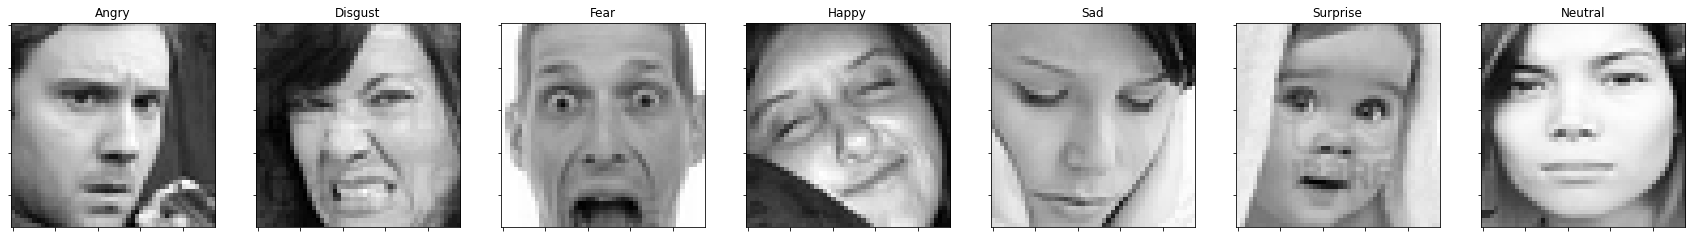

In [55]:
plot_all_emotions()

## Angry

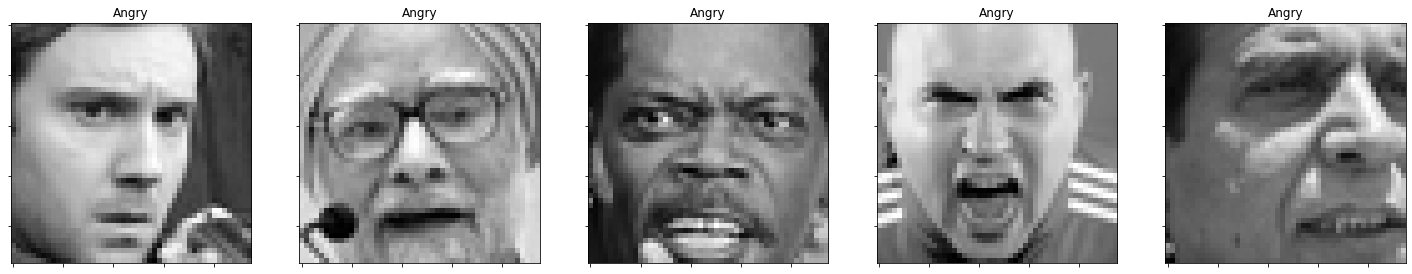

In [ ]:
plot_examples(label=0)

## Disgust

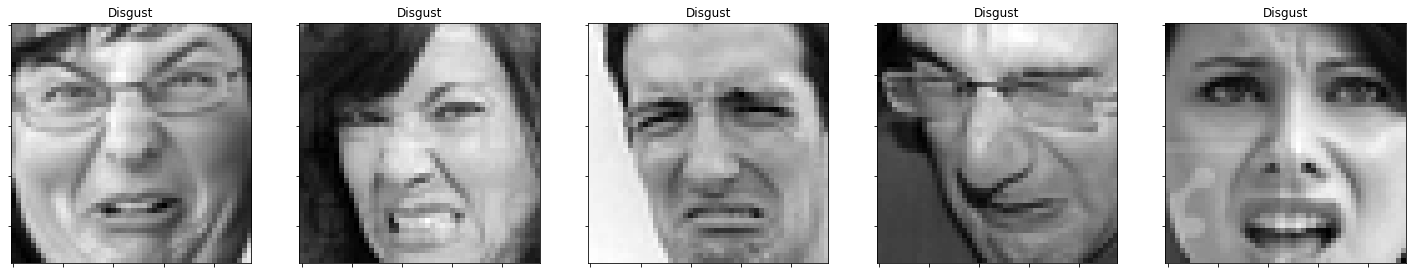

In [ ]:
plot_examples(label=1)

## Fear

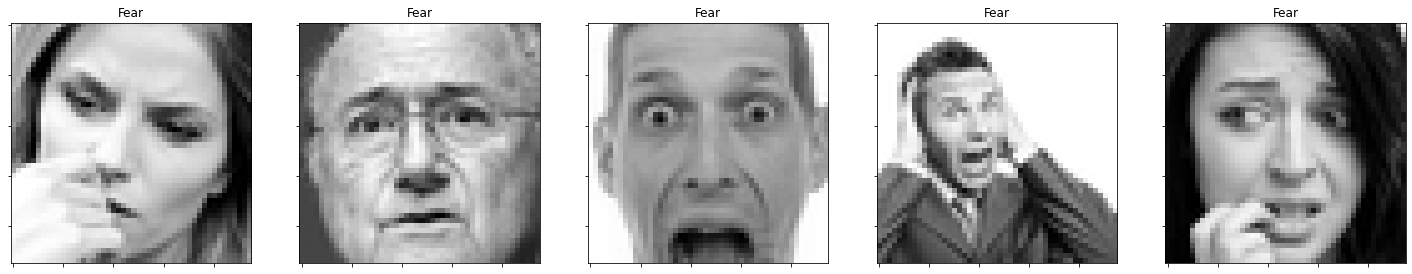

In [ ]:
plot_examples(label=2)

## Happy

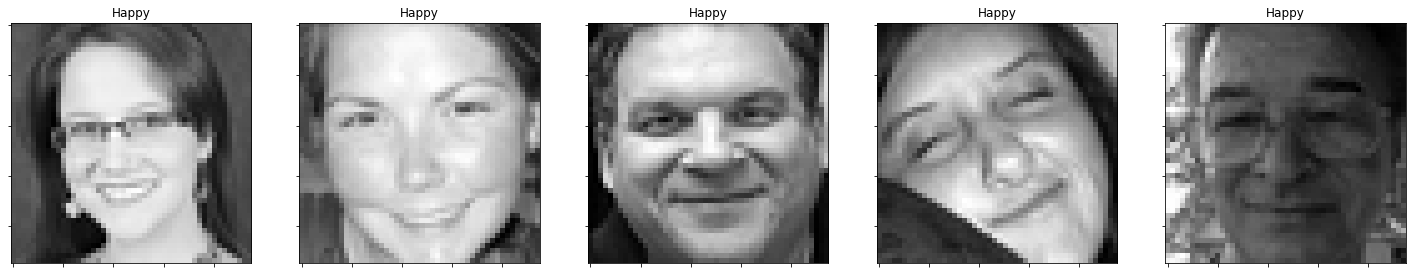

In [ ]:
plot_examples(label=3)


## Sad

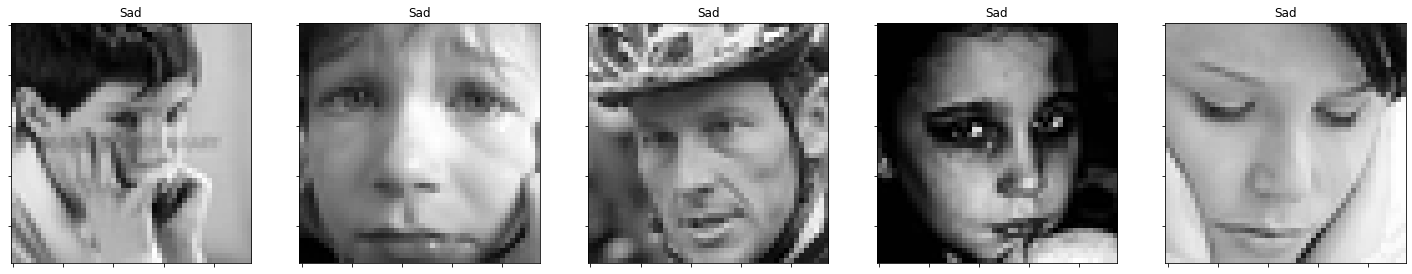

In [ ]:
plot_examples(label=4)

## Surprise

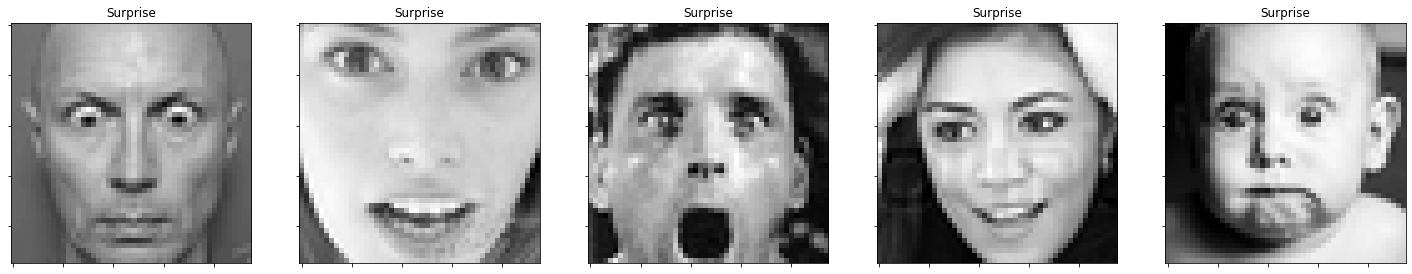

In [ ]:
plot_examples(label=5)

## Neutral

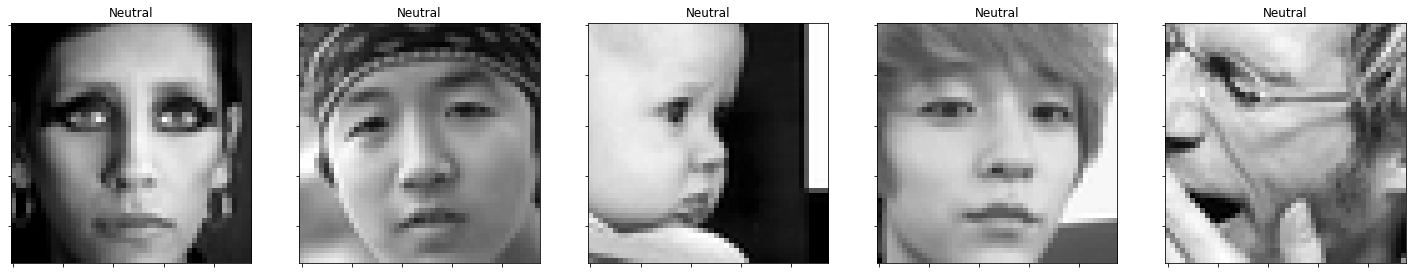

In [ ]:
plot_examples(label=6)

# <h1 style='background:#CCCCCC; border:0; color:black'><center><span style="color: royalblue;"><span style="color: royalblue;">Distribution Of Labels</span></span></center></h1> 

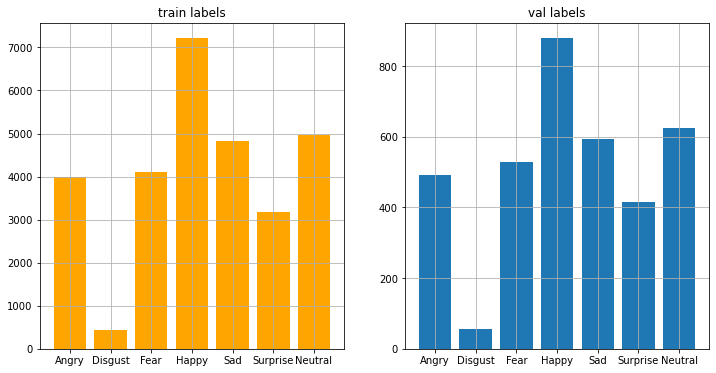

In [29]:
plot_compare_distributions(train_labels, val_labels, title1='train labels', title2='val labels')

# <h1 style='background:#CCCCCC; border:0; color:black'><center><span style="color: royalblue;"><span style="color: royalblue;">Class Weights</span></span></center></h1> 
Calculate the class weights of the label distribution:

In [56]:
class_weight = dict(zip(range(0, 7), (((data[data[' Usage']=='Training']['emotion'].value_counts()).sort_index())/len(data[data[' Usage']=='Training']['emotion'])).tolist()))

In [57]:
class_weight

{0: 0.1391549688251071,
 1: 0.01518687519593159,
 2: 0.14270786164617366,
 3: 0.2513149186666202,
 4: 0.16823992476226968,
 5: 0.11045316799609878,
 6: 0.17294228290779895}

# <h1 style='background:#CCCCCC; border:0; color:black'><center><span style="color: royalblue;"><span style="color: royalblue;">Model</span></span></center></h1> 
We define a simple CNN model:

In [58]:
model = models.Sequential()
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(48, 48, 1)))
model.add(MaxPool2D((2, 2)))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPool2D((2, 2)))
model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(Flatten())
model.add(Dense(64, activation='relu'))
model.add(Dense(7, activation='softmax'))

In [59]:
model.compile(optimizer=Adam(learning_rate=1e-3), loss='categorical_crossentropy', metrics=['accuracy'])

In [60]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 46, 46, 32)        320       
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 23, 23, 32)       0         
 2D)                                                             
                                                                 
 conv2d_7 (Conv2D)           (None, 21, 21, 64)        18496     
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 10, 10, 64)       0         
 2D)                                                             
                                                                 
 conv2d_8 (Conv2D)           (None, 8, 8, 128)         73856     
                                                                 
 flatten_2 (Flatten)         (None, 8192)             

In [61]:
history = model.fit(train_images, train_labels,
                    validation_data=(val_images, val_labels),
                    class_weight = class_weight,
                    epochs=12,
                    batch_size=64)

Epoch 1/12
449/449 [==============================] - 27s 59ms/step - loss: 0.2654 - accuracy: 0.3220 - val_loss: 1.6092 - val_accuracy: 0.3909
Epoch 2/12
449/449 [==============================] - 31s 68ms/step - loss: 0.2290 - accuracy: 0.4298 - val_loss: 1.4626 - val_accuracy: 0.4455
Epoch 3/12
449/449 [==============================] - 32s 72ms/step - loss: 0.2106 - accuracy: 0.4794 - val_loss: 1.4175 - val_accuracy: 0.4628
Epoch 4/12
449/449 [==============================] - 35s 79ms/step - loss: 0.1969 - accuracy: 0.5131 - val_loss: 1.3222 - val_accuracy: 0.5021
Epoch 5/12
449/449 [==============================] - 40s 88ms/step - loss: 0.1874 - accuracy: 0.5355 - val_loss: 1.3251 - val_accuracy: 0.5046
Epoch 6/12
449/449 [==============================] - 40s 89ms/step - loss: 0.1784 - accuracy: 0.5617 - val_loss: 1.3324 - val_accuracy: 0.5149
Epoch 7/12
449/449 [==============================] - 40s 90ms/step - loss: 0.1702 - accuracy: 0.5812 - val_loss: 1.2624 - val_accuracy:

In [63]:
test_loss, test_acc = model.evaluate(test_images, test_labels)
print('test caccuracy:', test_acc)


113/113 [==============================] - 1s 9ms/step - loss: 1.3374 - accuracy: 0.5397
test caccuracy: 0.5397046804428101


In [68]:
pred_test_labels = model.predict(test_images)
model.save("C:\\Users\\sanje\\Desktop\\emotion")

INFO:tensorflow:Assets written to: C:\Users\sanje\Desktop\emotion\assets


# <h1 style='background:#CCCCCC; border:0; color:black'><center><span style="color: royalblue;"><span style="color: royalblue;">Analyse Convergence</span></span></center></h1> 

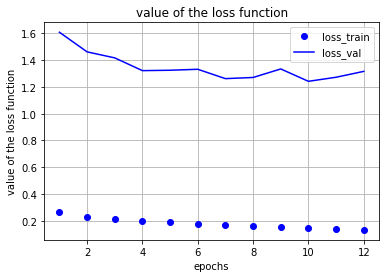

In [65]:
loss = history.history['loss']
loss_val = history.history['val_loss']
epochs = range(1, len(loss)+1)
plt.plot(epochs, loss, 'bo', label='loss_train')
plt.plot(epochs, loss_val, 'b', label='loss_val')
plt.title('value of the loss function')
plt.xlabel('epochs')
plt.ylabel('value of the loss function')
plt.legend()
plt.grid()
plt.show()

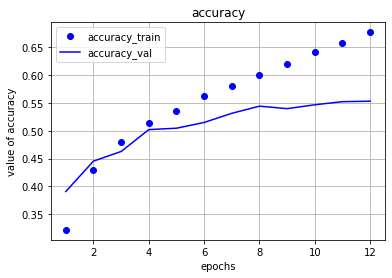

In [66]:
acc = history.history['accuracy']
acc_val = history.history['val_accuracy']
epochs = range(1, len(loss)+1)
plt.plot(epochs, acc, 'bo', label='accuracy_train')
plt.plot(epochs, acc_val, 'b', label='accuracy_val')
plt.title('accuracy')
plt.xlabel('epochs')
plt.ylabel('value of accuracy')
plt.legend()
plt.grid()
plt.show()

# <h1 style='background:#CCCCCC; border:0; color:black'><center><span style="color: royalblue;"><span style="color: royalblue;">Analyse Results</span></span></center></h1> 

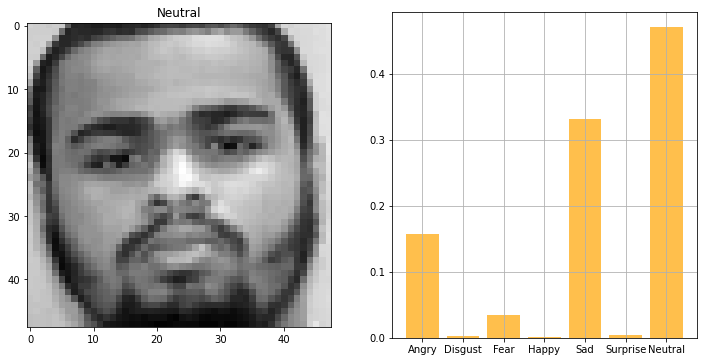

In [67]:
plot_image_and_emotion(test_image_array, test_image_label, pred_test_labels, 106)

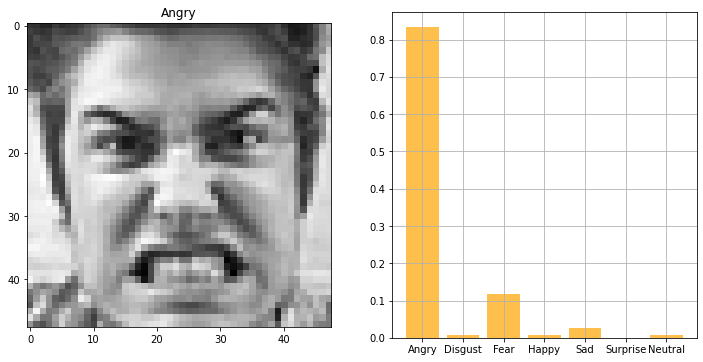

In [41]:
plot_image_and_emotion(test_image_array, test_image_label, pred_test_labels, 40)

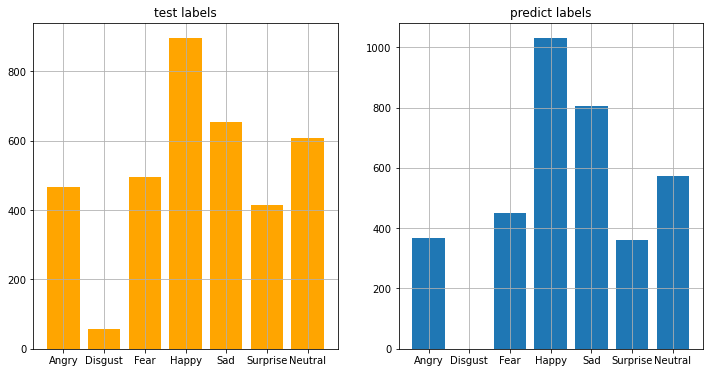

In [42]:
plot_compare_distributions(test_labels, pred_test_labels, title1='test labels', title2='predict labels')

# <h1 style='background:#CCCCCC; border:0; color:black'><center><span style="color: royalblue;"><span style="color: royalblue;">Analyse Wrong Prediction</span></span></center></h1> 
The accuracy score is about 54% on the test set. So it is obvious to take focus on the wrong predictions. We want to extract details to improve the model.

In [43]:
df_compare = pd.DataFrame()
df_compare['real'] = test_labels.argmax(axis=1)
df_compare['pred'] = pred_test_labels.argmax(axis=1)
df_compare['wrong'] = np.where(df_compare['real']!=df_compare['pred'], 1, 0)

C:\Users\sanje\AppData\Local\Temp/ipykernel_17708/94775150.py:8: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


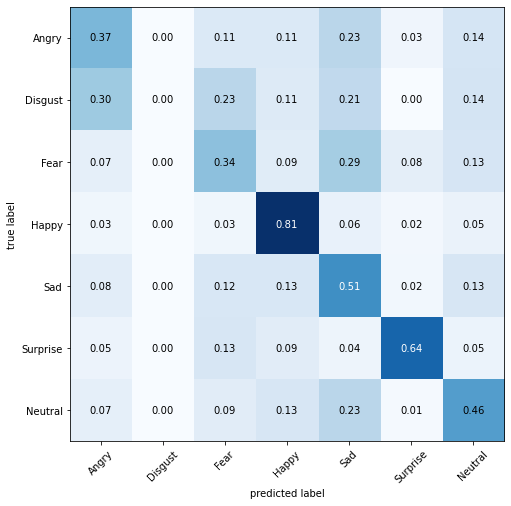

In [44]:
conf_mat = confusion_matrix(test_labels.argmax(axis=1), pred_test_labels.argmax(axis=1))

fig, ax = plot_confusion_matrix(conf_mat=conf_mat,
                                show_normed=True,
                                show_absolute=False,
                                class_names=emotions.values(),
                                figsize=(8, 8))
fig.show()